# [UCR] Guide to load dataset for inference 


## LeRobot Format

* This tutorial will show how to load data in LeRobot Format by using our dataloader. 
* We will use the `robot_sim.PickNPlace` dataset as an example which is already converted to LeRobot Format. 
* To understand how to convert your own dataset, please refer to [Gr00t's LeRobot.md](LeRobot_compatible_data_schema.md)

In [13]:
from gr00t.utils.misc import any_describe
from gr00t.data.dataset import LeRobotSingleDataset
from gr00t.data.dataset import ModalityConfig
from gr00t.data.schema import EmbodimentTag

## Loading the dataset

We need to define 3 things to load the dataset:
1. Path to the dataset

2. `ModalityConfigs`

- `ModalityConfigs` defines what data modalities (like video, state, actions, language) to use downstream like model training or inference.
- Each modality specifies which frame to load via delta_indices (e.g. [0] means current frame only, [-1,0] means previous and current frame)

3. `EmbodimentTag`
- `EmbodimentTag` is used to specify the embodiment of the dataset. A list of all the embodiment tags can be found in `gr00t.data.embodiment_tags.EmbodimentTag`.
- GR00T's architecture has different action heads optimized for specific robot types (embodiments). `EmbodimentTag` tells the model which action head to use for fine-tuning and/or inference. In our case, since we're using a humanoid arm, we specify `EmbodimentTag.GR1_UNIFIED` to get the best performance from the humanoid-specific action head.


In [14]:

import os
import gr00t

# REPO_PATH is the path of the pip install gr00t repo and one level up
REPO_PATH = os.path.dirname(os.path.dirname(gr00t.__file__))
DATA_PATH = os.path.join(REPO_PATH, "datasets/ucr_data/0626")

print("Loading dataset... from", DATA_PATH)

Loading dataset... from /home/wenda/src/Isaac-GR00T/datasets/ucr_data/0626


In [20]:
# 2. modality configs
modality_configs = {
    "video": ModalityConfig(
        delta_indices=[0],
        modality_keys=["video.ego_view"],
    ),
    "state": ModalityConfig(
        delta_indices=[0],
        modality_keys=[
            "state.waist_joint",
            "state.right_arm_joint",
            "state.left_arm_joint",
        ],
    ),
    "action": ModalityConfig(
        delta_indices=[0],
        modality_keys=[
            "action.left_ee_position",
            "action.right_ee_position",
        ],
    ),
    "language": ModalityConfig(
        delta_indices=[0],
        modality_keys=["annotation.human.action.task_description"],
    ),
}

In [21]:
# 3. gr00t embodiment tag
embodiment_tag = EmbodimentTag.GR1

# load the dataset
dataset = LeRobotSingleDataset(DATA_PATH, modality_configs,  embodiment_tag=embodiment_tag)

print('\n'*2)
print("="*100)
print(f"{' Humanoid Dataset ':=^100}")
print("="*100)

# print the 7th data point
resp = dataset[10]
any_describe(resp)
print(resp.keys())

Initialized dataset 0626 with EmbodimentTag.GR1



========================================= Humanoid Dataset =========================================
{'action.left_ee_position': 'np: [1, 3] float64',
 'action.right_ee_position': 'np: [1, 3] float64',
 'annotation.human.action.task_description': ['Toss the box in front'],
 'state.left_arm_joint': 'np: [1, 5] float64',
 'state.right_arm_joint': 'np: [1, 5] float64',
 'state.waist_joint': 'np: [1, 3] float64',
 'video.ego_view': 'np: [1, 224, 224, 3] uint8'}
dict_keys(['video.ego_view', 'state.waist_joint', 'state.right_arm_joint', 'state.left_arm_joint', 'action.left_ee_position', 'action.right_ee_position', 'annotation.human.action.task_description'])


Show Image frames within the data


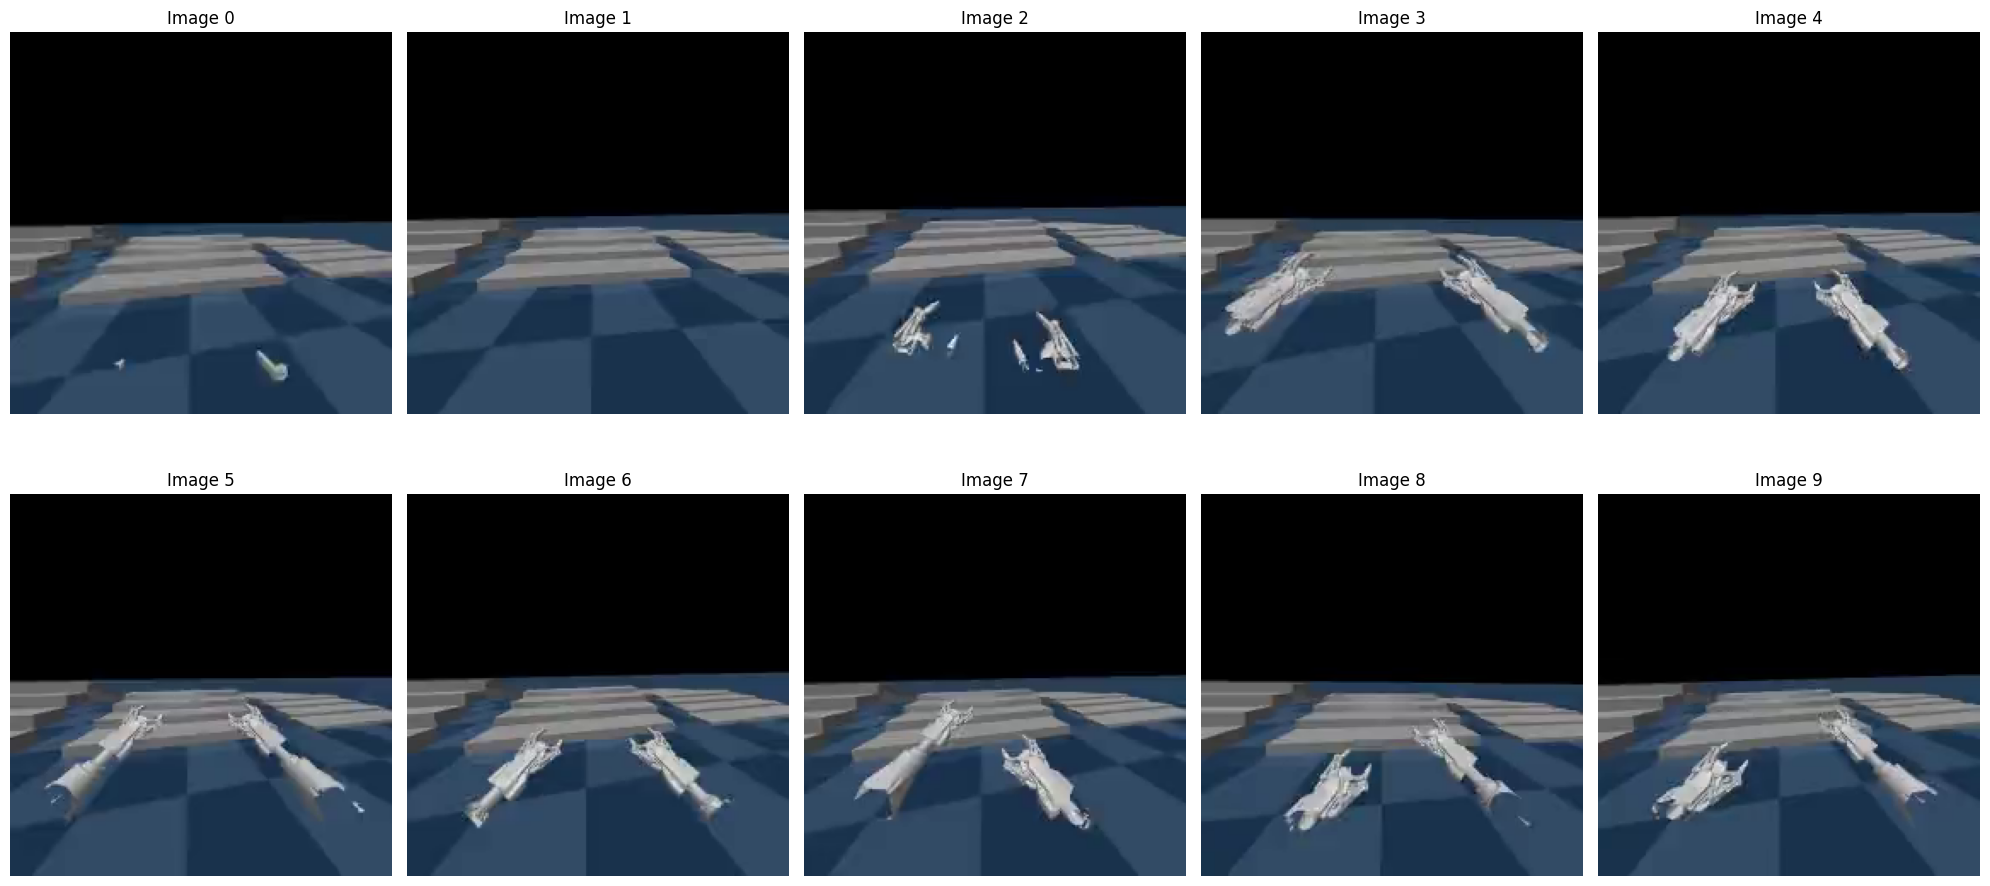

In [22]:
# show img
import matplotlib.pyplot as plt

images_list = []

for i in range(100):
    if i % 10 == 0:
        resp = dataset[i]
        img = resp["video.ego_view"][0]
        images_list.append(img)


fig, axs = plt.subplots(2, 5, figsize=(20, 10))
for i, ax in enumerate(axs.flat):
    ax.imshow(images_list[i])
    ax.axis("off")
    ax.set_title(f"Image {i}")
plt.tight_layout() # adjust the subplots to fit into the figure area.
plt.show()


## Transforming the data

We can also apply a series of transformation to the data to our `LeRobotSingleDataset` class. This shows how to apply transformations to the data.

In [23]:
from gr00t.data.transform.base import ComposedModalityTransform
from gr00t.data.transform import VideoToTensor, VideoCrop, VideoResize, VideoColorJitter, VideoToNumpy
from gr00t.data.transform.state_action import StateActionToTensor, StateActionTransform
from gr00t.data.transform.concat import ConcatTransform


video_modality = modality_configs["video"]
state_modality = modality_configs["state"]
action_modality = modality_configs["action"]

# select the transforms you want to apply to the data
to_apply_transforms = ComposedModalityTransform(
    transforms=[
        # video transforms
        VideoToTensor(apply_to=video_modality.modality_keys),
        VideoCrop(apply_to=video_modality.modality_keys, scale=0.95),
        VideoResize(apply_to=video_modality.modality_keys, height=224, width=224, interpolation="linear"),
        VideoColorJitter(apply_to=video_modality.modality_keys, brightness=0.3, contrast=0.4, saturation=0.5, hue=0.08),
        VideoToNumpy(apply_to=video_modality.modality_keys),

        # state transforms
        StateActionToTensor(apply_to=state_modality.modality_keys),
        StateActionTransform(apply_to=state_modality.modality_keys, normalization_modes={
            key: "min_max" for key in state_modality.modality_keys
        }),

        # action transforms
        StateActionToTensor(apply_to=action_modality.modality_keys),
        StateActionTransform(apply_to=action_modality.modality_keys, normalization_modes={
            key: "min_max" for key in action_modality.modality_keys
        }),

        # ConcatTransform
        ConcatTransform(
            video_concat_order=video_modality.modality_keys,
            state_concat_order=state_modality.modality_keys,
            action_concat_order=action_modality.modality_keys,
        ),
    ]
)

Now see how the data is different after applying the transformations.

e.g. states and actions are being normalized and concatenated, video images are being cropped, resized, and color-jittered.

In [24]:
dataset = LeRobotSingleDataset(
    DATA_PATH,
    modality_configs,
    transforms=to_apply_transforms,
    embodiment_tag=embodiment_tag
)

# print the 7th data point
resp = dataset[7]
any_describe(resp)
print(resp.keys())


Initialized dataset 0626 with EmbodimentTag.GR1
{'action': 'torch: [1, 6] torch.float64 cpu',
 'annotation.human.action.task_description': ['Toss the box in front'],
 'state': 'torch: [1, 13] torch.float64 cpu',
 'video': 'np: [1, 1, 224, 224, 3] uint8'}
dict_keys(['annotation.human.action.task_description', 'video', 'state', 'action'])
